In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as sc

In [2]:
hf = h5py.File("SkyNet_r-process.h5")
list(hf)

['A',
 'BindingEnergy',
 'Density',
 'Dt',
 'Entropy',
 'EtaE',
 'HeatingRate',
 'Temperature',
 'Time',
 'Y',
 'Ye',
 'Z']

In [3]:
#This section defines temperature, time, and the extended parts of it.
temperature = hf["Temperature"]
time = hf["Time"]
mod_temp = []
full_temp = []
m = (np.log10(temperature[1700]) - np.log10(temperature[1600])) / (np.log10(time[1700]) - np.log10(time[1600]))
for i in range(0,len(temperature)):
    if i < 1700:
        mod_temp.append(np.log10(temperature[i]))
        full_temp.append(temperature[i])
    else:
        del_t = m*(np.log10(time[i]) - np.log10(time[i-1]))
        mod_temp.append(mod_temp[i-1]+del_t)
        full_temp.append(10**mod_temp[i])


In [4]:
## Trying to extract the data for abundances for Samarium
abundance = hf["Y"]
mass = hf["A"]
charge = hf["Z"]
index_list = []
full_abundance = []

for i in range(len(charge)):
    if charge[i] == 62: ##charge of samarium
        index_list.append(i)
        
full_abundance = np.sum(abundance[:, index_list], 1)


From this point onward, I shall code the equations necessary to find the abundances. The two code sections above this markdown only had the purpose of creating the full_temp and full_abundance arrays!

Arrays required for this calculation: func(full_temp, density , Y_e(I need free but I'm given full) , ionization_potentials, full_abundance)

List of actual variable names:
full_temp,
density,
electron_free --> electron_full,
ion_potential,
full_abundance


NOTE: Almost all the values in the NIST table are theoretical values...Not observed in a lab besides the very first value!

In [5]:
density = hf["Density"]
electron_full = np.array(hf["Ye"])
f = 1
electron_free = f * electron_full
electron_bound = (1-f) * electron_full
ion_potential = np.array([5.64371,11.078,23.55,41.64,62.7,87,103,118,141,158,179,208,237,257,276,306.5,474,506,543,581,617,658,702,742,782,822,976,1016,1060,1103,1180,1226,1332,1381.6,2371,2466,2569,2676,2782,2887,3028,3137,3253,3363,3669,3766,3873,3971,4227,4337,4548,4655,10494,10762,11060,11337,12264,12588,12992,13262.85,53986.12,55214.23])
Z = 62

In [6]:
kbEvpGK = 8.617e-5*1e9
def g_i(den,elec_full,temp,ion):
    a = -ion / (kbEvpGK * temp)
    return (2/(den * 1e6 * sc.N_A * elec_full * f)) * (((sc.electron_mass * sc.k *  temp * np.power(10,9)) / (2 * sc.pi * sc.hbar**2))**1.5) * np.exp(a)

In [7]:
#Let us first try a random index for the abundance since it makes calculations more testable!
summation = 0
k=-1
abun_zero = full_abundance[k]

for i in range(Z+1):
    product = 1 #np.ones(full_abundance.shape)
    for j in range(i):
        product*= g_i(density[k],full_abundance[k]*Z,full_temp[k],ion_potential[j])
    summation+=product
    
calculated_abun = abun_zero / summation
print(calculated_abun, abun_zero, full_temp[k]*kbEvpGK)

6.932621682462392e-05 6.932621682462392e-05 0.00011577011188132991


In [8]:
# This box calculates the total array of neutral abundances across time
summation = np.zeros(full_abundance.shape)

full_abundance = np.array(full_abundance)
full_temp = np.array(full_temp)
density = np.array(density)

for i in range(Z+1):
    product = np.ones(full_abundance.shape)
    for j in range(i):
        product *= g_i(density, full_abundance*Z, full_temp, ion_potential[j])
    summation+=product
    
neutral_abun = full_abundance/summation
neutral_ln_abun = np.log(full_abundance) - np.log(summation)
print(neutral_abun)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.94730279e-05
 6.93909822e-05 6.93262168e-05]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Fractions of Neutral over Full Abundances')

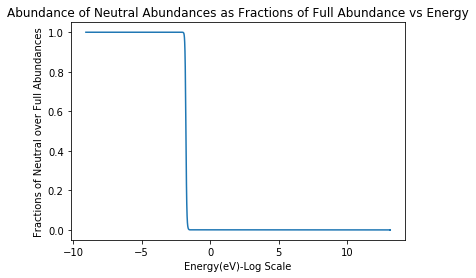

In [9]:
plt.plot(np.log(full_temp*kbEvpGK), neutral_abun/full_abundance)
plt.title("Abundance of Neutral Abundances as Fractions of Full Abundance vs Energy")
plt.xlabel("Energy(eV)-Log Scale")
plt.ylabel("Fractions of Neutral over Full Abundances")

In [10]:
#This box is for finding the abundances of all the charge states across time
charge_state = np.zeros((full_abundance.shape[0], len(ion_potential)+1))
charge_state[:,0] = neutral_abun
for (j, xi) in enumerate(ion_potential):
    for i in range(len(neutral_abun)):
        charge_state[i, j+1]=(charge_state[i, j] * g_i(density[i], full_abundance[i]*Z, full_temp[i], xi))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0, 0.5, 'Fractions of state 1 over Full Abundances')

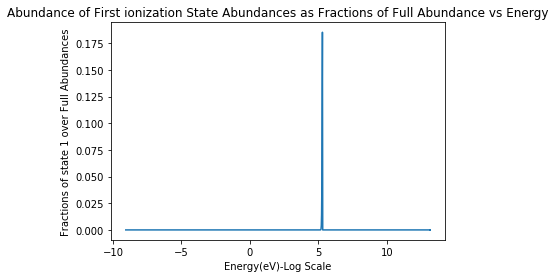

In [11]:
plt.plot(np.log(full_temp*kbEvpGK), charge_state[:,50]/full_abundance)
plt.title("Abundance of First ionization State Abundances as Fractions of Full Abundance vs Energy")
plt.xlabel("Energy(eV)-Log Scale")
plt.ylabel("Fractions of state 1 over Full Abundances")


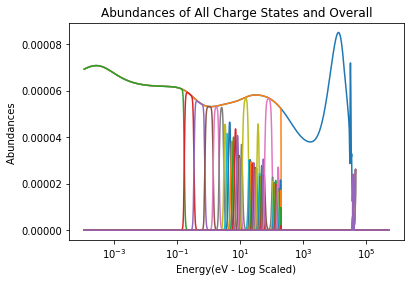

In [12]:
plt.semilogx(full_temp*kbEvpGK,full_abundance)
plt.semilogx(full_temp*kbEvpGK, np.sum(charge_state, 1))
for i in range(len(charge_state[0,:])):
    plt.semilogx(full_temp*kbEvpGK, charge_state[:,i])
plt.xlabel("Energy(eV - Log Scaled)")
plt.ylabel("Abundances ")
plt.title("Abundances of All Charge States and Overall")
plt.yscale('linear')


(10000, 100000)

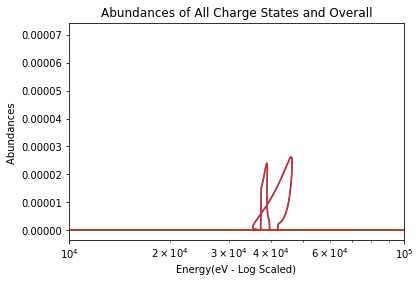

In [13]:
#plt.semilogx(full_temp*kbEvpGK,full_abundance)
plt.semilogx(full_temp*kbEvpGK, np.sum(charge_state, 1))
for i in range(len(charge_state[0,:])):
    plt.semilogx(full_temp*kbEvpGK, charge_state[:,i])
plt.xlabel("Energy(eV - Log Scaled)")
plt.ylabel("Abundances ")
plt.title("Abundances of All Charge States and Overall")
plt.yscale('linear')
plt.xlim(10000,100000)

(100, 1000000)

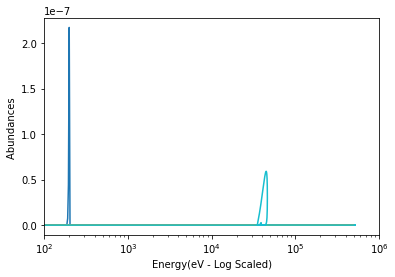

In [14]:
for i in range(52,62):
    plt.semilogx(full_temp*kbEvpGK, charge_state[:,i])

plt.xlabel("Energy(eV - Log Scaled)")
plt.ylabel("Abundances ")
plt.yscale('linear')
plt.xlim(100,1000000)